In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

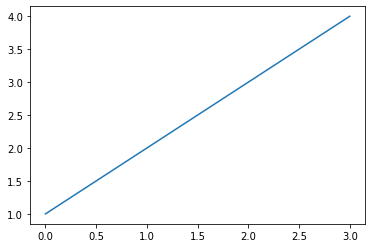

In [2]:
plt.plot([1,2,3,4])

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [4]:
emb_dim = 12 
model_dim = 16
h = 4
d_v = d_k = d_q = model_dim//h
bs = 2
seq_len = 20

In [5]:
emb_dim = 12
model_dim = 16
seq_len = 20

W_q = nn.Linear(emb_dim,model_dim)
W_k = nn.Linear(emb_dim,model_dim)
W_v = nn.Linear(emb_dim,model_dim)

In [6]:
input_seq = torch.randn(seq_len,emb_dim)

In [7]:
q = W_q(input_seq)
k = W_k(input_seq)
v = W_v(input_seq)

In [8]:
print(q.shape)
print(k.shape)
print(v.shape)

torch.Size([20, 16])
torch.Size([20, 16])
torch.Size([20, 16])


In [9]:
h = 4
q_ = q.chunk(h,dim=-1)
k_ = k.chunk(h,dim=-1)
v_ = v.chunk(h,dim=-1)

In [10]:
q_[2].size()

torch.Size([20, 4])

In [11]:
k_[2].T.size()

torch.Size([4, 20])

In [12]:
scaled_dot_products = []

for i in range(h):
    dot = (q_[i] @ k_[i].T)/np.sqrt(emb_dim/h)
    scaled_dot_products.append(dot)

In [13]:
scaled_dot_products[0].size()

torch.Size([20, 20])

In [14]:
softmax = nn.Softmax(dim=1)

In [15]:
attn_wgts = []
for m in scaled_dot_products:
    attn_wgts.append(softmax(m))    

In [16]:
attn_wgts[0].sum(1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000], grad_fn=<SumBackward1>)

In [17]:
weighted_values = []
for i in range(h):
    weighted_values.append(attn_wgts[i] @ v_[i])

In [18]:
weighted_values[0].shape

torch.Size([20, 4])

In [19]:
out_h = torch.cat(weighted_values,dim=1)

In [20]:
out_h.shape

torch.Size([20, 16])

In [21]:
W_o = nn.Linear(model_dim,emb_dim)
o = W_o(out_h)

In [22]:
o.shape

torch.Size([20, 12])

In [23]:
o = input_seq + o

In [24]:
ln_1 = nn.LayerNorm(12)

In [25]:
o = ln_1(o)

In [26]:
o.shape

torch.Size([20, 12])

In [ ]:
o.std(dim=1)

In [27]:
ff_layer = nn.Sequential(nn.Linear(12,2024),
                            nn.ReLU(),
                            nn.Linear(2024,12))                           

In [28]:
ln_2 = nn.LayerNorm(12)

In [29]:
output = ln_2(o + ff_layer(o))

In [30]:
output.shape

torch.Size([20, 12])

## Positional Embedding

In [ ]:
div_term = np.array([np.exp(-2*i/12 * np.log(10000)) for i in range(0,100,2)])

In [ ]:
position = np.array([float(i)  for i in range(16)])
pe = np.zeros((100,12))
pe[:,0::2] = np.sin(np.multiply.outer(position,div_term))
pe[:,1::2] = np.cos(np.multiply.outer(position,div_term))

In [ ]:
np.multiply.outer(position,div_term).shape

In [ ]:
pe.shape #sequence_len,embedding_dim

In [34]:
p_5 = [np.cos(- 5 * np.exp((-2*j/emb_dim)*np.log(10000))) for j in range(emb_dim)]
p_5

[0.28366218546322625,
 0.47378072050724973,
 0.9731902242785206,
 0.9987502603949663,
 0.9999419807006283,
 0.9999973069578462,
 0.9999998750000026,
 0.999999994198014,
 0.9999999997306956,
 0.9999999999875,
 0.9999999999994198,
 0.999999999999973]

In [33]:
p_5

[0.28366218546322625,
 0.47378072050724973,
 0.9731902242785206,
 0.9987502603949663,
 0.9999419807006283,
 0.9999973069578462,
 0.9999998750000026,
 0.999999994198014,
 0.9999999997306956,
 0.9999999999875,
 0.9999999999994198,
 0.999999999999973]

In [35]:
position = torch.arange(100)
position

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
        90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [62]:
pe = torch.zeros(100,48)

In [63]:
div_term_even = torch.exp(-(2 * np.log(10000)/48)*torch.arange(0,48,2))
div_term_odd = torch.exp(-(2 * np.log(10000)/48)*torch.arange(1,48,2))

In [64]:
(torch.arange(100).to(torch.float).unsqueeze(1) @ div_term_even.unsqueeze(0))

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 4.6416e-01, 2.1544e-01,  ..., 1.0000e-07, 4.6416e-08,
         2.1544e-08],
        [2.0000e+00, 9.2832e-01, 4.3089e-01,  ..., 2.0000e-07, 9.2832e-08,
         4.3089e-08],
        ...,
        [9.7000e+01, 4.5023e+01, 2.0898e+01,  ..., 9.7000e-06, 4.5023e-06,
         2.0898e-06],
        [9.8000e+01, 4.5488e+01, 2.1113e+01,  ..., 9.8000e-06, 4.5488e-06,
         2.1113e-06],
        [9.9000e+01, 4.5952e+01, 2.1329e+01,  ..., 9.9000e-06, 4.5952e-06,
         2.1329e-06]])

In [66]:
div_term_even.size()

torch.Size([24])

In [67]:
pe[:,0::2] = torch.sin((torch.arange(100).to(torch.float).unsqueeze(1) @ div_term_even.unsqueeze(0)))
pe[:,1::2] = torch.cos((torch.arange(100).to(torch.float).unsqueeze(1) @ div_term_odd.unsqueeze(0)))

In [55]:
pe.numpy()

array([[ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00, ...,
         1.0000000e+00,  0.0000000e+00,  1.0000000e+00],
       [ 8.4147096e-01,  9.7688168e-01,  4.6399228e-02, ...,
         1.0000000e+00,  2.1544356e-07,  1.0000000e+00],
       [ 9.0929741e-01,  9.0859562e-01,  9.2698507e-02, ...,
         1.0000000e+00,  4.3088713e-07,  1.0000000e+00],
       ...,
       [ 3.7960774e-01, -4.5970735e-01, -9.7802097e-01, ...,
         1.0000000e+00,  2.0898025e-05,  1.0000000e+00],
       [-5.7338190e-01, -6.3893133e-01, -9.8664224e-01, ...,
         1.0000000e+00,  2.1113468e-05,  1.0000000e+00],
       [-9.9920684e-01, -7.8861475e-01, -9.9313813e-01, ...,
         1.0000000e+00,  2.1328913e-05,  1.0000000e+00]], dtype=float32)

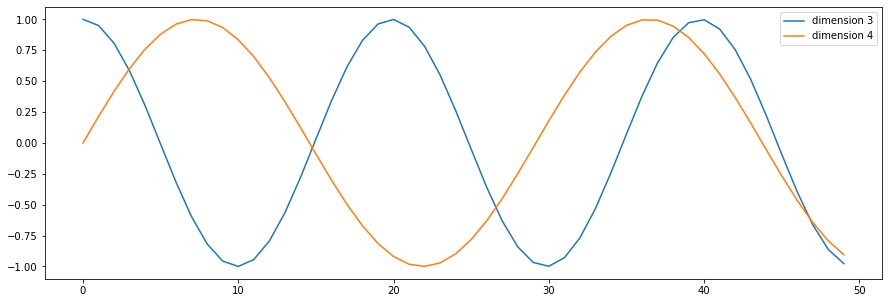

In [69]:
plt.figure(figsize=(15, 5))
plt.plot(range(0,50),pe.numpy()[:50,[3,4]]);
plt.legend(['dimension %d' %p for p in [3,4] ])


In [ ]:
plt.figure(figsize=(15,5))
plt.plot(range(0,20),pe.T[:,[1,2,20]]);
plt.legend(['position %d' %p for p in [1,2,6]])

In [ ]:
pe[3,:] #the positional embedding for position 3 in the sentence

In [ ]:
torch.from_numpy(pe)[:,None,:].size()

In [ ]:
inp = inp + torch.from_numpy(pe)[:,None,:].float()

In [ ]:
inp.size()

In [ ]:
class PositionalEncoder(nn.Module):
    def __init__(self,emb_dim,dropout=0,max_sent_len=5000):
        super().__init__()
        
        self.emb_dim = emb_dim
        self.dropout = nn.Dropout(dropout)
        self.max_sent_len = max_sen_length
        
        self.div_term = torch.tensor(torch.exp(-2*i/self.emb_dim * torch.log(10000)) for i in torch.arange(0,self.emb_dim,2))
        
        self.position = torch.arange(self.max_sent_len)
        
        self.pe = torch.zeros(self.max_sent_len,self.emb_dim)
        
        self.pe[:,0::2] = torch.sin(self.position * self.div_term)
        self.pe[:,1::2] = torch.cos(self.position * self.div_term)
        
    def forward(self,encoded_seq):
        
        x =  encoded_seq + self.pe[:,:x.size(1)]
        return self.dropout(x)
            

In [ ]:
encoder_layer = nn.TransformerEncoderLayer(12,3)

In [ ]:
outp = encoder_layer(inp)

In [ ]:
outp.size()  #sequence_len,batch_size,embedding_dim

In [ ]:
encoder = nn.TransformerEncoder(encoder_layer,6)

In [ ]:
outp = encoder(inp) #this is just composing encoder_layer with itself 6 times

## Decoder

In [70]:
target_len = 6

In [96]:
target = torch.rand(bs,target_len,emb_dim) #The target sequence may have different length than the input seq

In [97]:
target.size()

torch.Size([2, 6, 12])

In [112]:
bool_mask = torch.triu(input_seq.new_ones(6,6), diagonal=1).bool()
mask = bool_mask.float()
mask

tensor([[0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0.]])

In [113]:
mask = mask.float().masked_fill(bool_mask,-float('inf')).type_as(mask)

In [114]:
mask

tensor([[0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0.]])

In [98]:
emb_dim = 12
model_dim = 12
seq_len = 6

Wd_q = nn.Linear(emb_dim,model_dim)
Wd_k = nn.Linear(emb_dim,model_dim)
Wd_v = nn.Linear(emb_dim,model_dim)

In [99]:
qd = Wd_q(target)
kd = Wd_k(target)
vd = Wd_v(target)

In [100]:
h = 4
qd_ = qd.chunk(h,dim=-1)
kd_ = kd.chunk(h,dim=-1)
vd_ = vd.chunk(h,dim=-1)

In [101]:
qd_[0].shape

torch.Size([2, 6, 3])

In [104]:
scores = []

for i in range(h):
    dot = (qd_[i] @ kd_[i].transpose(1,2))/np.sqrt(emb_dim/h)
    scores.append(dot)

In [105]:
scores[0].size()

torch.Size([2, 6, 6])

In [120]:
scores[0]

tensor([[[-0.0285,  0.0121, -0.0333, -0.0404,  0.0154, -0.0270],
         [-0.0058,  0.0797,  0.0305,  0.0041,  0.0582,  0.0532],
         [ 0.0007,  0.0875,  0.0133,  0.0033,  0.0485,  0.0426],
         [-0.0456,  0.0143, -0.0262, -0.0539,  0.0345, -0.0226],
         [ 0.0659,  0.2095,  0.1047,  0.0974,  0.0936,  0.1706],
         [-0.0470,  0.0345, -0.0193, -0.0532,  0.0489, -0.0098]],

        [[ 0.0071,  0.0983,  0.0215,  0.0948, -0.0832, -0.0108],
         [ 0.0119,  0.1661,  0.1080,  0.2046, -0.1184,  0.0282],
         [-0.0109,  0.0450,  0.0790,  0.0965, -0.0445,  0.0347],
         [ 0.0195,  0.1031,  0.0900,  0.1325, -0.0424,  0.0367],
         [-0.1676, -0.2012, -0.0684, -0.0990, -0.1392, -0.0491],
         [-0.0359, -0.0070,  0.0174,  0.0304, -0.0579,  0.0002]]],
       grad_fn=<DivBackward0>)

In [121]:
masked_scores = [scores[i].masked_fill(bool_mask, -float('inf')) for i in range(h)]

In [118]:
masked_scores[0]

tensor([[[-0.0285,    -inf,    -inf,    -inf,    -inf,    -inf],
         [-0.0058,  0.0797,    -inf,    -inf,    -inf,    -inf],
         [ 0.0007,  0.0875,  0.0133,    -inf,    -inf,    -inf],
         [-0.0456,  0.0143, -0.0262, -0.0539,    -inf,    -inf],
         [ 0.0659,  0.2095,  0.1047,  0.0974,  0.0936,    -inf],
         [-0.0470,  0.0345, -0.0193, -0.0532,  0.0489, -0.0098]],

        [[ 0.0071,    -inf,    -inf,    -inf,    -inf,    -inf],
         [ 0.0119,  0.1661,    -inf,    -inf,    -inf,    -inf],
         [-0.0109,  0.0450,  0.0790,    -inf,    -inf,    -inf],
         [ 0.0195,  0.1031,  0.0900,  0.1325,    -inf,    -inf],
         [-0.1676, -0.2012, -0.0684, -0.0990, -0.1392,    -inf],
         [-0.0359, -0.0070,  0.0174,  0.0304, -0.0579,  0.0002]]],
       grad_fn=<MaskedFillBackward0>)

In [122]:
attn_wgts = [F.softmax(masked_scores[i],2) for i in range(h)]

In [124]:
attn_wgts[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4786, 0.5214, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3222, 0.3514, 0.3263, 0.0000, 0.0000, 0.0000],
        [0.2455, 0.2607, 0.2503, 0.2435, 0.0000, 0.0000],
        [0.1903, 0.2197, 0.1979, 0.1964, 0.1957, 0.0000],
        [0.1601, 0.1737, 0.1646, 0.1591, 0.1762, 0.1662]],
       grad_fn=<SelectBackward0>)

In [125]:
[attn_wgts[i] @ vd_[i] for i in range(h)]

[tensor([[[ 0.2358,  0.1666, -0.2084],
          [ 0.1652,  0.1369, -0.2012],
          [ 0.2301,  0.2206, -0.1972],
          [ 0.2357,  0.2137, -0.2305],
          [ 0.1918,  0.1780, -0.2118],
          [ 0.2082,  0.2296, -0.1852]],
 
         [[ 0.0545,  0.2453, -0.2914],
          [ 0.0931,  0.2300, -0.2193],
          [ 0.0975,  0.1336, -0.2211],
          [ 0.1925,  0.1445, -0.2197],
          [ 0.1754,  0.0929, -0.2479],
          [ 0.2393,  0.1326, -0.2367]]], grad_fn=<UnsafeViewBackward0>),
 tensor([[[ 0.0947, -0.4660, -0.3562],
          [ 0.1799, -0.4463, -0.2624],
          [ 0.1203, -0.6119, -0.2513],
          [ 0.0925, -0.6418, -0.2843],
          [ 0.1373, -0.6537, -0.3071],
          [ 0.1181, -0.7033, -0.2837]],
 
         [[ 0.2571, -0.5933, -0.4796],
          [ 0.1415, -0.5648, -0.4037],
          [ 0.0804, -0.4964, -0.4134],
          [ 0.0435, -0.4707, -0.3468],
          [ 0.0216, -0.4684, -0.3295],
          [ 0.0275, -0.5827, -0.3180]]], grad_fn=<UnsafeViewBac

In [126]:
out_hd = torch.cat([attn_wgts[i] @ vd_[i] for i in range(h)],dim=2)

In [128]:
out_hd.size()

torch.Size([2, 6, 12])

In [ ]:
def masked_attn(Q,K,V):
    score = torch.bmm(Q,K.transpose(1,2))/np.sqrt(d_k)
    masked_score = score.masked_fill(bool_mask, -float('inf')).type_as(score)
    return torch.bmm(F.softmax(masked_score,2),V)

In [ ]:
x = [masked_attn(Q,K,V) for Q,K,V in zip(q,k,v)]

In [ ]:
x[0].size()

In [ ]:
interm_outp = torch.cat(x,2)

In [ ]:
interm_outp.size()

In [ ]:
layer_norm_dec_1 = nn.LayerNorm(d_e)

In [ ]:
interm_outp = layer_norm_dec_1(tar_ + interm_outp)

In [ ]:
enc_outp = outp.transpose(0,1)

In [ ]:
W_Q_dec_2 = nn.ModuleList([nn.Linear(d_e,d_q) for _ in range(h)])
W_K_dec_2 = nn.ModuleList([nn.Linear(d_e,d_k) for _ in range(h)])
W_V_dec_2 =nn.ModuleList([nn.Linear(d_e,d_v) for _ in range(h)])
 

In [ ]:
q_dec_2 = [l(interm_outp) for l in W_Q_dec_2]
k_dec_2 = [l(enc_outp) for l in W_K_dec_2]
v_dec_2 = [l(enc_outp) for l in W_V_dec_2]

In [ ]:
q_dec_2[0].size()

In [ ]:
k_dec_2[0].size()

In [ ]:
x = [attn(Q,K,V) for Q,K,V in zip(q_dec_2,k_dec_2,v_dec_2)]

In [ ]:
x = torch.cat(x,2)

In [ ]:
x.size()

In [ ]:
layer_norm_2 = nn.LayerNorm(d_e)

In [ ]:
dec_outp = layer_norm_2(x + interm_outp)

In [ ]:
dec_outp.size()

In [ ]:
dec_layer = nn.TransformerDecoderLayer(d_e,3)

In [ ]:
target.size()   # the Pytorch classes take tensors in the format (sequence_len,batch_size,embedding_dim)

In [ ]:
dec_layer(target,outp,tgt_mask=mask)

In [ ]:
forward(tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None)


In [ ]:
transformer = nn.Transformer(d_e,3,6)

In [ ]:
transformer(inp,target,tgt_mask=mask)

In [ ]:
target.size()

In [ ]:
inp.size()